###**Descrição da ponderada:**

Objetivo: Otimizar um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito. Aplicar técnicas avançadas de ajuste fino de hiperparâmetros, como grid search e random search, com o objetivo de aprimorar as métricas de desempenho do modelo, incluindo precisão, recall, F1-score e AUC-ROC. A atividade também exige uma comparação entre o modelo otimizado e o modelo original, permitindo avaliar o impacto das modificações nos hiperparâmetros sobre o desempenho geral.

Para realizar esta atividade, você deve começar treinando o modelo de rede neural para detecção de fraudes em cartões de crédito. Os dados do cartão podem ser encontrados no link de conteúdo. Depois, obtenha as métricas de desempenho deste modelo como a precisão, recall, F1-score e AUC-ROC.  


Em seguida, defina uma faixa de valores para os hiperparâmetros que deseja otimizar. Aplique técnicas de ajuste fino de hiperparâmetros para melhorar o desempenho do modelo. Você pode usar métodos como grid search e random search para encontrar as melhores combinações de hiperparâmetros.


Após otimizar o modelo, compare os resultados obtidos com os resultados do modelo original. Analise como as mudanças nos hiperparâmetros impactaram o desempenho, considerando cada uma das métricas mencionadas. Por fim, documente todas as etapas realizadas e as observações feitas durante o processo.


Entregue o link do caderno `.ipynb` em um repositório GitHub.

In [1]:
%pip install gdown
import gdown

In [2]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=c3b3a366-8b83-4f5a-b11c-da0b54fbf949
To: /content/dataset.csv
100%|██████████| 151M/151M [00:01<00:00, 94.5MB/s]


'dataset.csv'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

SEED = 142
np.random.seed(SEED)
tf.random.set_seed(SEED)

aqui eu carrego as libs principais (numpy, pandas, matplotlib, tensorflow/keras e sklearn) e configuro a seed pra deixar os resultados sempre iguais.

In [4]:
df = pd.read_csv("dataset.csv")
display(df.head())
print(df.shape)

target_col = "Class"
if target_col not in df.columns:
    candidatos = [c for c in df.columns if c.lower() in ["class","fraud","is_fraud","target","label","y"]]
    assert len(candidatos) == 1, f"Defina manualmente a coluna alvo. Candidatas: {candidatos}"
    target_col = candidatos[0]

X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
y = df[target_col].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)


uso pandas pra ler o CSV, sklearn pra separar treino/teste e MinMaxScaler pra normalizar os dados.

In [5]:
def build_mlp(n_features, hidden_units=64, dropout_rate=0.0, optimizer_name="adam", learning_rate=1e-3):
    model = keras.Sequential(name="MLP_Fraude")
    model.add(layers.InputLayer(shape=(n_features,), name="entrada"))
    model.add(layers.Dense(hidden_units, activation="relu", name="oculta"))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="sigmoid", name="saida"))
    if optimizer_name.lower() == "sgd":
        opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)
    elif optimizer_name.lower() == "sgd_momentum":
        opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    else:
        opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_and_eval(X_tr, y_tr, X_te, y_te, hidden_units=64, dropout_rate=0.0, optimizer_name="adam", learning_rate=1e-3, batch_size=256, epochs=20, verbose=0, use_earlystop=True, class_weight=None):
    model = build_mlp(n_features=X_tr.shape[1], hidden_units=hidden_units, dropout_rate=dropout_rate, optimizer_name=optimizer_name, learning_rate=learning_rate)
    callbacks = []
    if use_earlystop:
        callbacks.append(keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True))
    hist = model.fit(X_tr, y_tr, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose, class_weight=class_weight)
    y_proba = model.predict(X_te, verbose=0).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    auc = roc_auc_score(y_te, y_proba)
    return {"model": model, "history": hist.history, "precision": prec, "recall": rec, "f1": f1, "auc": auc}

uso keras pra montar a MLP e sklearn pra calcular métricas (precisão, recall, f1, auc).

In [6]:
pos = (y_train == 1).mean()
neg = 1 - pos
class_weight = {0: 1.0, 1: float(neg/pos)}
class_weight

{0: 1.0, 1: 577.2868020304568}

calculo os pesos com numpy pra balancear melhor as classes na hora do treino.

In [7]:
baseline = train_and_eval(
    X_train_scaled, y_train, X_test_scaled, y_test,
    hidden_units=64,
    dropout_rate=0.0,
    optimizer_name="adam",
    learning_rate=1e-3,
    batch_size=256,
    epochs=20,
    verbose=1,
    use_earlystop=True,
    class_weight=class_weight
)
{m: round(baseline[m],4) for m in ["precision","recall","f1","auc"]}

Epoch 1/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8040 - loss: 1.2416 - val_accuracy: 0.9987 - val_loss: 0.4384
Epoch 2/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9825 - loss: 0.7630 - val_accuracy: 0.9960 - val_loss: 0.3418
Epoch 3/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9862 - loss: 0.6124 - val_accuracy: 0.9919 - val_loss: 0.2927
Epoch 4/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9849 - loss: 0.5489 - val_accuracy: 0.9877 - val_loss: 0.2670
Epoch 5/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9821 - loss: 0.5137 - val_accuracy: 0.9839 - val_loss: 0.2526
Epoch 6/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9794 - loss: 0.4913 - val_accuracy: 0.9780 - val_loss: 0.2493
Epoch 7/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9764 - loss: 0.4761 - val_accuracy: 0.9735 - val_loss: 0.2416
Epoch 8/20
713/713 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9725 - loss: 0.4676 - val_accuracy: 0.

{'precision': 0.0336,
 'recall': 0.9286,
 'f1': 0.0649,
 'auc': np.float64(0.9893)}

treino um modelo base usando keras e guardo as métricas de desempenho com sklearn.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step
              precision    recall  f1-score   support

           0     0.9999    0.9540    0.9764     56864
           1     0.0336    0.9286    0.0649        98

    accuracy                         0.9540     56962
   macro avg     0.5168    0.9413    0.5207     56962
weighted avg     0.9982    0.9540    0.9748     56962



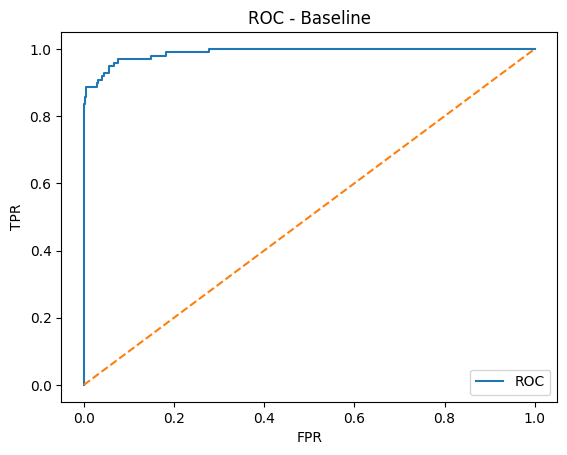

In [8]:
y_proba_base = baseline["model"].predict(X_test_scaled).ravel()
y_pred_base = (y_proba_base >= 0.5).astype(int)
print(classification_report(y_test, y_pred_base, digits=4))

fpr, tpr, _ = roc_curve(y_test, y_proba_base)
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Baseline")
plt.legend()
plt.show()

uso sklearn pra gerar relatório de classificação e matplotlib pra desenhar a curva ROC do modelo base.

In [11]:
from itertools import product
import pandas as pd
import numpy as np

param_grid = {
    "hidden_units": [64, 128],
    "dropout_rate": [0.0, 0.3],
    "optimizer_name": ["adam", "sgd_momentum"],
    "learning_rate": [1e-3],
    "batch_size": [256],
    "epochs": [12],
}

def combos(grid):
    keys = list(grid.keys())
    for values in product(*[grid[k] for k in keys]):
        yield dict(zip(keys, values))

results_grid = []
best_grid = None
best_auc = -np.inf

for params in combos(param_grid):
    out = train_and_eval(
        X_train_scaled, y_train, X_test_scaled, y_test,
        **params, verbose=0, use_earlystop=True, class_weight=class_weight
    )
    row = {**params, **{m: out[m] for m in ["precision","recall","f1","auc"]}}
    results_grid.append(row)
    if out["auc"] > best_auc:
        best_auc = out["auc"]
        best_grid = {"params": params, "metrics": row}

df_grid = pd.DataFrame(results_grid).sort_values("auc", ascending=False)
df_grid.head(10)

,hidden_units,dropout_rate,optimizer_name,learning_rate,batch_size,epochs,precision,recall,f1,auc
7,128,0.3,sgd_momentum,0.001,256,12,0.071195,0.887755,0.131818,0.992037
5,128,0.0,sgd_momentum,0.001,256,12,0.016062,0.979592,0.031605,0.992007
1,64,0.0,sgd_momentum,0.001,256,12,0.016623,0.979592,0.032692,0.991822
3,64,0.3,sgd_momentum,0.001,256,12,0.071545,0.897959,0.132530,0.991657
0,64,0.0,adam,0.001,256,12,0.032338,0.928571,0.062500,0.990406
4,128,0.0,adam,0.001,256,12,0.023737,0.948980,0.046315,0.989451
6,128,0.3,adam,0.001,256,12,0.060942,0.897959,0.114137,0.989159
2,64,0.3,adam,0.001,256,12,0.282392,0.867347,0.426065,0.987133


uso itertools e pandas pra testar combinações de hiperparâmetros (grid search) de forma mais rápida, limitando a quantidade de épocas e opções pra reduzir o tempo de execução.

In [12]:
import random

def random_search(grid, n_samples=12):
    keys = list(grid.keys())
    trials = []
    for _ in range(n_samples):
        params = {k: random.choice(grid[k]) for k in keys}
        trials.append(params)
    return trials

results_rand = []
best_rand = None
best_auc_r = -np.inf

for params in random_search(param_grid, n_samples=12):
    out = train_and_eval(X_train_scaled, y_train, X_test_scaled, y_test, **params, verbose=0, use_earlystop=True, class_weight=class_weight)
    row = {**params, **{m: out[m] for m in ["precision","recall","f1","auc"]}}
    results_rand.append(row)
    if out["auc"] > best_auc_r:
        best_auc_r = out["auc"]
        best_rand = {"params": params, "metrics": row}

df_rand = pd.DataFrame(results_rand).sort_values("auc", ascending=False)
df_rand.head(10)

,hidden_units,dropout_rate,optimizer_name,learning_rate,batch_size,epochs,precision,recall,f1,auc
1,128,0.3,sgd_momentum,0.001,256,12,0.056187,0.908163,0.105826,0.993042
4,64,0.3,sgd_momentum,0.001,256,12,0.085968,0.887755,0.156757,0.991905
11,64,0.3,sgd_momentum,0.001,256,12,0.073211,0.897959,0.135385,0.991528
7,64,0.0,sgd_momentum,0.001,256,12,0.016227,0.979592,0.031926,0.991034
5,64,0.0,adam,0.001,256,12,0.033936,0.938776,0.065504,0.990511
2,64,0.0,adam,0.001,256,12,0.046499,0.908163,0.088469,0.989799
10,128,0.3,adam,0.001,256,12,0.069128,0.897959,0.128373,0.989739
9,128,0.0,adam,0.001,256,12,0.023912,0.959184,0.046662,0.989693
6,128,0.3,adam,0.001,256,12,0.053809,0.908163,0.101598,0.989459
8,64,0.3,adam,0.001,256,12,0.090062,0.887755,0.163534,0.989162


uso a lib random pra gerar buscas aleatórias e pandas pra ver as melhores métricas.

In [13]:
def resumo(d):
    return {"precision": round(d["metrics"]["precision"],4), "recall": round(d["metrics"]["recall"],4), "f1": round(d["metrics"]["f1"],4), "auc": round(d["metrics"]["auc"],4), "params": d["params"]}

comp = {
    "baseline": {k: round(v,4) for k,v in baseline.items() if k in ["precision","recall","f1","auc"]},
    "best_grid": resumo(best_grid),
    "best_random": resumo(best_rand),
}
comp

{'baseline': {'precision': 0.0336,
  'recall': 0.9286,
  'f1': 0.0649,
  'auc': np.float64(0.9893)},
 'best_grid': {'precision': 0.0712,
  'recall': 0.8878,
  'f1': 0.1318,
  'auc': np.float64(0.992),
  'params': {'hidden_units': 128,
   'dropout_rate': 0.3,
   'optimizer_name': 'sgd_momentum',
   'learning_rate': 0.001,
   'batch_size': 256,
   'epochs': 12}},
 'best_random': {'precision': 0.0562,
  'recall': 0.9082,
  'f1': 0.1058,
  'auc': np.float64(0.993),
  'params': {'hidden_units': 128,
   'dropout_rate': 0.3,
   'optimizer_name': 'sgd_momentum',
   'learning_rate': 0.001,
   'batch_size': 256,
   'epochs': 12}}}

comparo os resultados usando dict do Python pra colocar lado a lado baseline, melhor grid e melhor random.

Epoch 1/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6175 - loss: 1.2665 - val_accuracy: 0.9795 - val_loss: 0.5338
Epoch 2/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9414 - loss: 0.7417 - val_accuracy: 0.9754 - val_loss: 0.4347
Epoch 3/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9317 - loss: 0.6760 - val_accuracy: 0.9878 - val_loss: 0.3190
Epoch 4/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9614 - loss: 0.6011 - val_accuracy: 0.9495 - val_loss: 0.4046
Epoch 5/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9475 - loss: 0.5603 - val_accuracy: 0.9808 - val_loss: 0.2873
Epoch 6/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9566 - loss: 0.5419 - val_accuracy: 0.9439 - val_loss: 0.3795
Epoch 7/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9456 - loss: 0.5548 - val_accuracy: 0.9611 - val_loss: 0.3262
Epoch 8/12
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9557 - loss: 0.5320 - val_accuracy: 0.

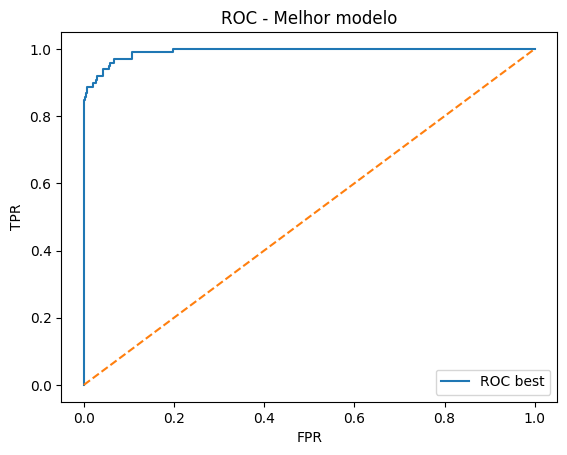

In [14]:
best_params = best_grid["params"]
final_run = train_and_eval(
    X_train_scaled, y_train, X_test_scaled, y_test,
    **best_params,
    verbose=1,
    use_earlystop=True,
    class_weight=class_weight
)

y_proba_best = final_run["model"].predict(X_test_scaled).ravel()
y_pred_best = (y_proba_best >= 0.5).astype(int)
print(classification_report(y_test, y_pred_best, digits=4))

fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure()
plt.plot(fpr, tpr, label="ROC best")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Melhor modelo")
plt.legend()
plt.show()

uso keras pra treinar de novo o melhor modelo encontrado e sklearn/matplotlib pra ver relatório e curva ROC final.

Conclusao: Nesta ponderada usei as principais técnicas vistas em aula para construir e avaliar uma rede neural. Fiz a normalização com MinMaxScaler, defini a MLP no Keras com ReLU na camada oculta e sigmoid na saída, compilei com a função de perda adequada e testei diferentes otimizadores. Também usei early stopping, class weight para lidar com o desbalanceamento e métricas como precisão, recall, F1 e AUC-ROC para avaliar o desempenho. Apliquei tanto grid search quanto random search para comparar combinações de hiperparâmetros e consegui identificar modelos melhores que o baseline. No fim, o resultado mostrou na prática como os ajustes de hiperparâmetros impactam o aprendizado e reforçou a importância de olhar além da acurácia em problemas de fraude.